In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import mal_cfr_data.plot as mcd_plt
import mal_cfr_data.tournament as mcd_tournament

mcd_plt.set_plt_params()
div_color_palette = mcd_plt.diverging_color_palette()
seq_color_palette = mcd_plt.sequential_color_palette()

In [3]:
data = mcd_tournament.Data.load()
data.data

,game_tag,sampler,seed,mode,row_alg,col_alg,value
0,tiny_bridge,null,4.0,shuffled,CFR,CFR,20.5007
1,tiny_bridge,null,4.0,shuffled,CFR,CFR_EX+IN,20.4541
2,tiny_bridge,null,4.0,shuffled,CFR,A-CFR,20.4079
3,tiny_bridge,null,4.0,shuffled,CFR,CFR_IN,20.3421
4,tiny_bridge,null,4.0,shuffled,CFR,A-CFR_IN,20.3358
...,...,...,...,...,...,...,...
2475,tiny_bridge,null,1.0,shuffled,BR,CFR_IN,20.5255
2476,tiny_bridge,null,1.0,shuffled,BR,A-CFR_IN,20.5191
2477,tiny_bridge,null,1.0,shuffled,BR,BPS-CFR,20.5914
2478,tiny_bridge,null,1.0,shuffled,BR,TIPS-CFR,20.5269


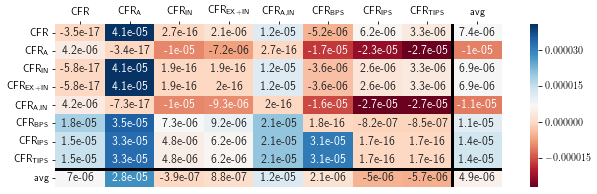

In [4]:
plt.figure(figsize=(10, 3))
mcd_tournament.heatmap(
    mcd_tournament.without_br_row(data.fixed_table('kuhn_3p')),
    cmap=div_color_palette
)

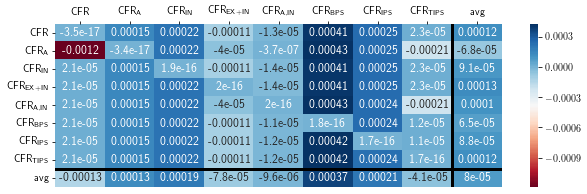

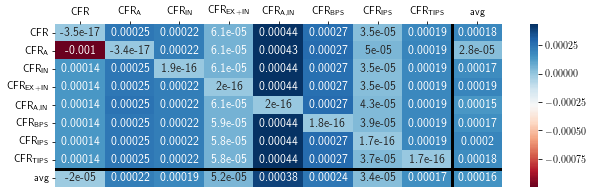

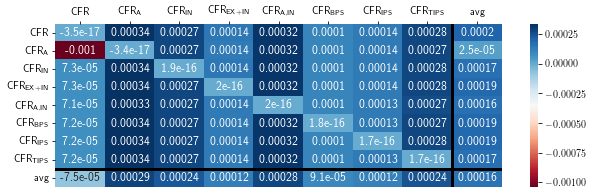

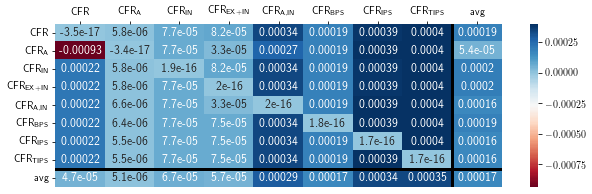

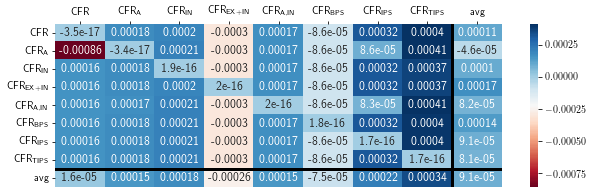

In [5]:
for seed in data.all_seeds():
    if not np.isnan(seed):
        plt.figure(figsize=(10, 3))
        mcd_tournament.heatmap(
            mcd_tournament.without_br_row(
                data.shuffled_table('kuhn_3p', seed)),
            cmap=div_color_palette)
        plt.show()

In [6]:
(data.shuffled_table_by_seed("kuhn_3p") * 1000).std().max()

0.25429632992200263

In [7]:
(data.max_abs_diff_from_mean("kuhn_3p") * 1000).max()

0.42434259999999996

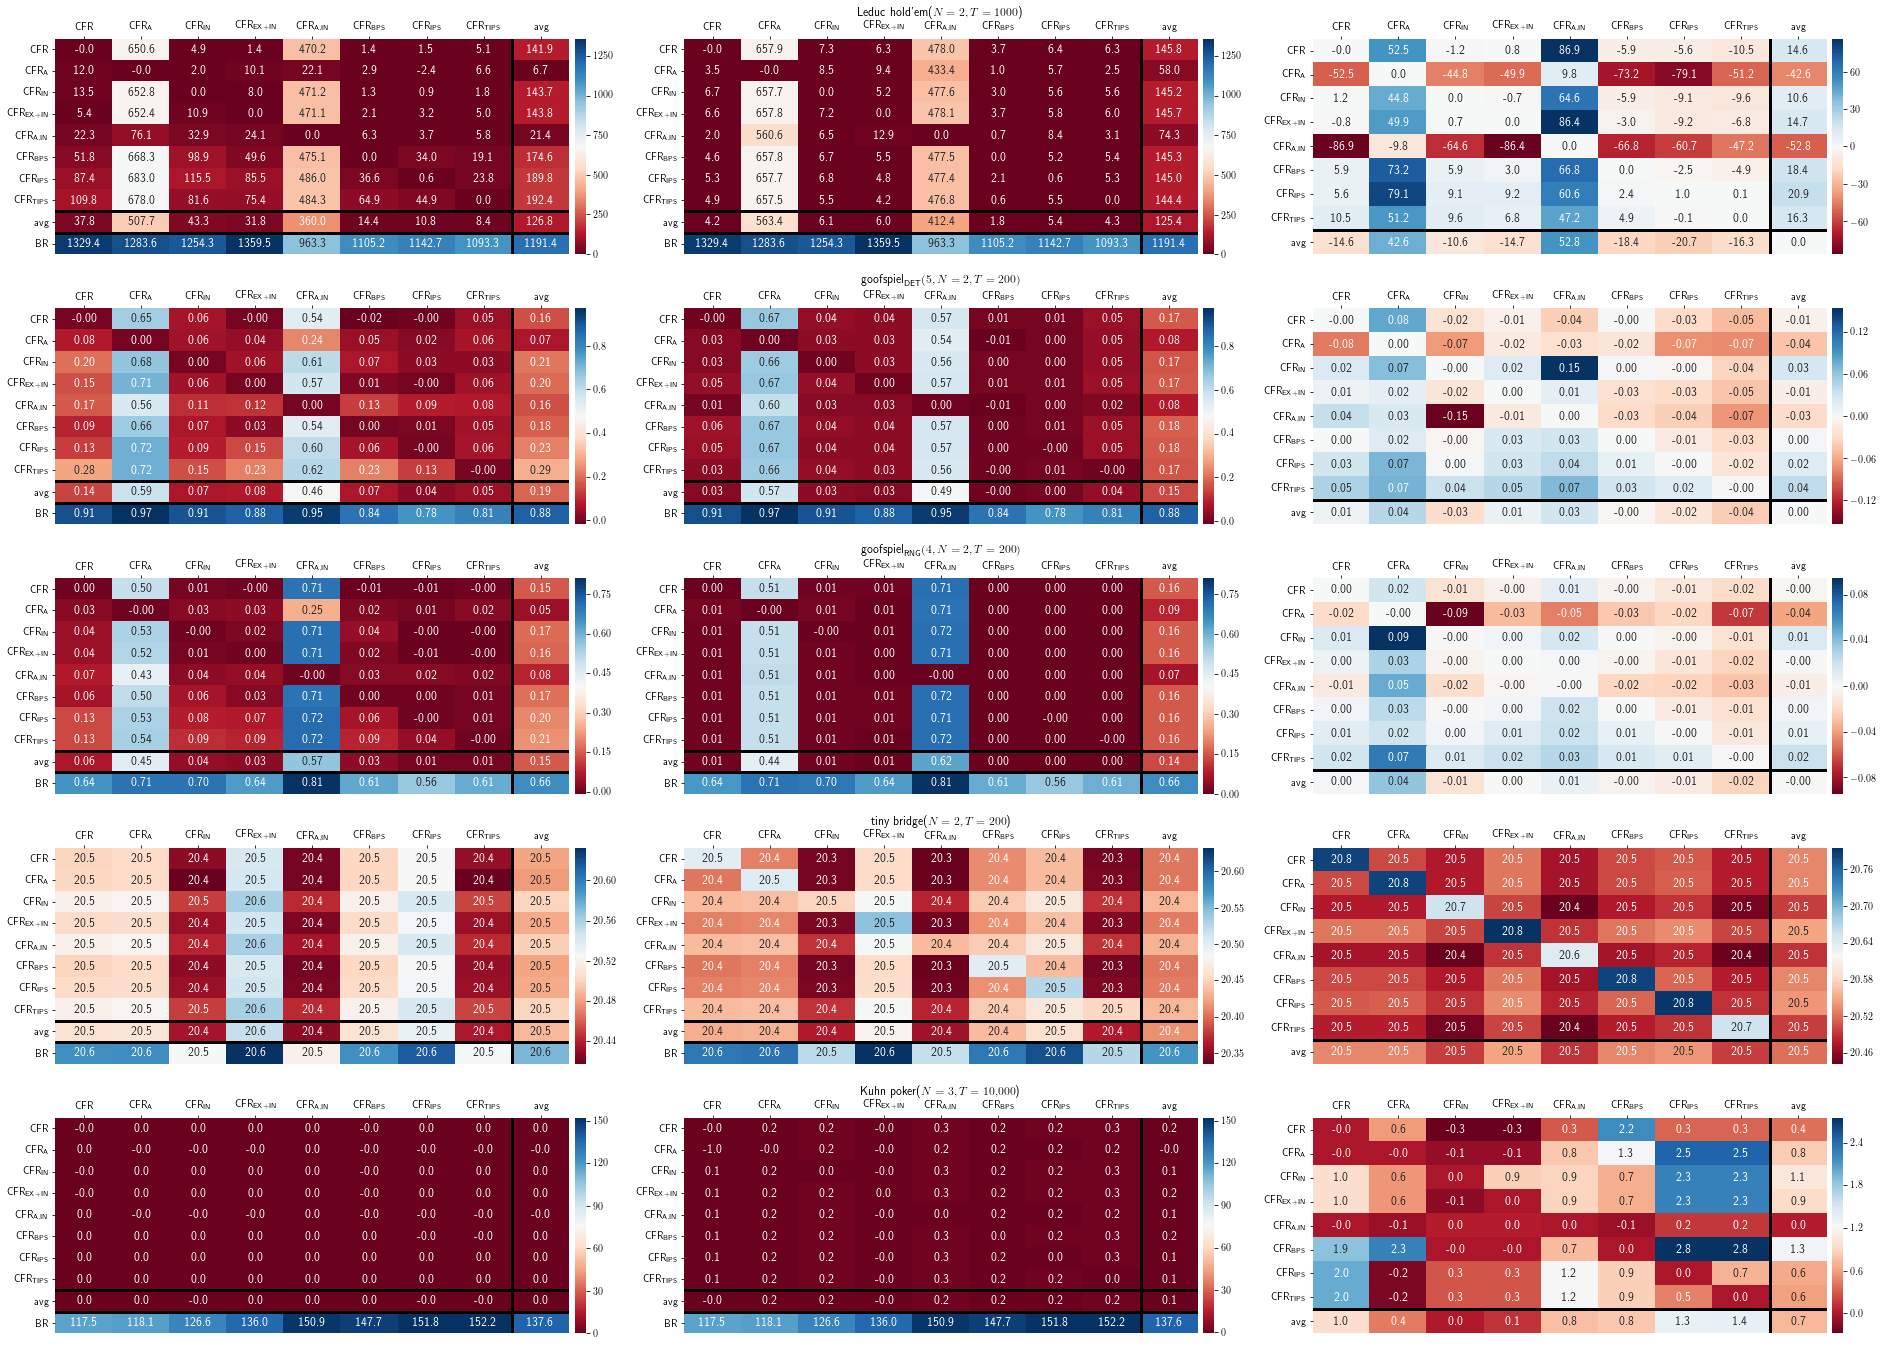

In [12]:
fig, axes_list = plt.subplots(
    len(data.games()),
    3,
    sharex=True,
    squeeze=False,
    figsize=(26, 3.7 * len(data.games())),
    gridspec_kw={'width_ratios': [1, 1, 1]})
for i, game in enumerate(data.games()):
    axes_list[i, 1].set_title(mcd_tournament.game_label(game))
    
    scale = 1000 if game == 'kuhn_3p' or game == 'leduc' else 1
    fmt = "0.2f" if game == 'goofspiel' or game == 'random_goofspiel' else "0.1f"
    
    mcd_tournament.heatmap(
        data.fixed_table(game) * scale,
        fmt=fmt,
        ax=axes_list[i, 0],
        cmap=div_color_palette,
        cbar_kws={'fraction': 0.05, 'pad': 0.01})
    mcd_tournament.heatmap(
        data.avg_shuffled_table(game) * scale,
        fmt=fmt,
        ax=axes_list[i, 1],
        cmap=div_color_palette,
        cbar_kws={'fraction': 0.05, 'pad': 0.01})
    mcd_tournament.heatmap(
        data.sim_table(game) * scale,
        fmt=fmt,
        ax=axes_list[i, 2],
        cmap=div_color_palette,
        cbar_kws={'fraction': 0.05, 'pad': 0.01})
plt.tight_layout(0)
plt.subplots_adjust(wspace=0.15, hspace=0.25)
fig.savefig(f'results/heatmaps.aug21_2020.pdf')
plt.show()

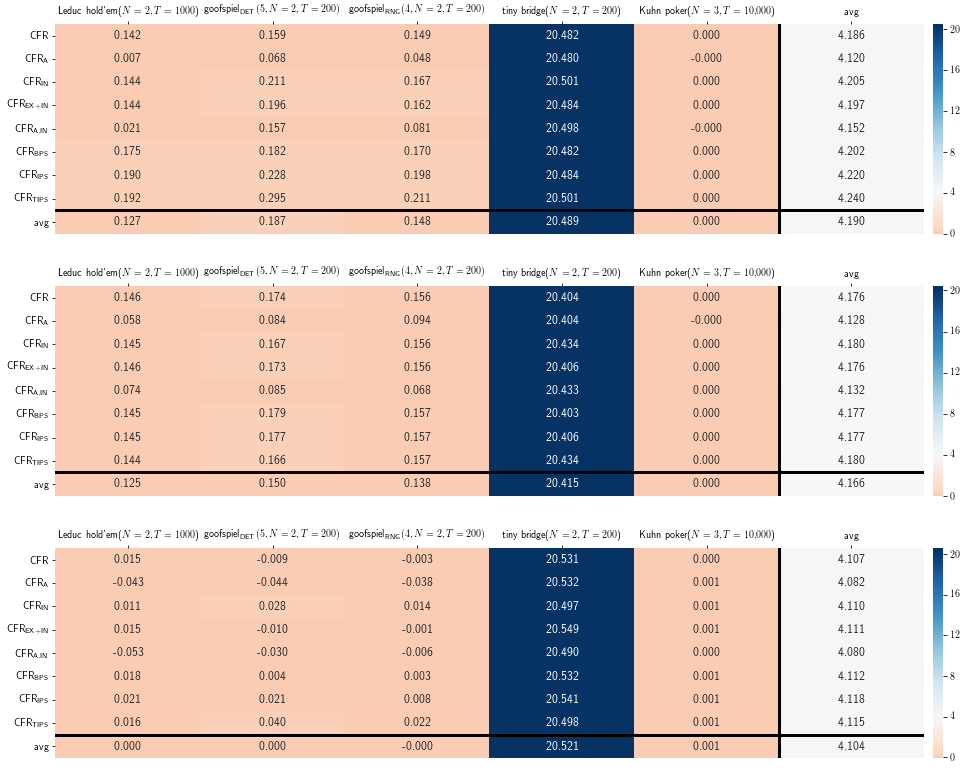

In [9]:
fig, axes_list = plt.subplots(
    3,
    1,
    sharex=True,
    sharey=True,
    squeeze=True,
    figsize=(13.5, 3.5 * 3))
mcd_tournament.heatmap_avg(
    mcd_tournament.without_br_row(data.fixed_avg_table()),
    ax=axes_list[0],
    cmap=div_color_palette,
    cbar_kws={'fraction': 0.05, 'pad': 0.01},
    fmt="0.3f"
)
mcd_tournament.heatmap_avg(
    mcd_tournament.without_br_row(data.shuffled_avg_table()),
    ax=axes_list[1],
    cmap=div_color_palette,
    cbar_kws={'fraction': 0.05, 'pad': 0.01},
    fmt="0.3f"
)
mcd_tournament.heatmap_avg(
    mcd_tournament.without_br_row(data.sim_avg_table()),
    ax=axes_list[2],
    cmap=div_color_palette,
    cbar_kws={'fraction': 0.05, 'pad': 0.01},
    fmt="0.3f"
)
plt.tight_layout(0)
plt.subplots_adjust(hspace=0.25)
fig.savefig(f'results/avg_heatmaps.aug22_2020.pdf')
plt.show()